In [ ]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as snsv
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [ ]:
pre_post_test_df = pd.read_csv('pre_post_test_analysis.csv')
behavioural_df = pd.read_csv('behavioural_analysis.csv')
fnirs_df = pd.read_csv('fnirs_analysis.csv')
eye_tracking_df = pd.read_csv('eye_tracking_analysis.csv')  

merged_df = pre_post_test_df.merge(behavioural_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(fnirs_df, on=['participant_number', 'subexperiment_number'])
merged_df = merged_df.merge(eye_tracking_df, on=['participant_number', 'subexperiment_number']) 

merged_df.to_csv('master.csv', index=False)
print("master.csv has been updated successfully.")

master.csv has been updated successfully.


### Calculate Median and Upper Quartile Split using 9-point Paas Score

In [ ]:
file_path = "master.csv"
df = pd.read_csv(file_path)

subject_col = 'participant_number'

median_thresholds = []
quartile_thresholds = []

def perform_splits(group):
    # Calculate the subject-specific median for the 9-point Paas score
    median_value = group['feedback_score_subexperiment'].median()
    group['median_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= median_value else 0
    )
    
    # Calculate the subject-specific 75th percentile (upper quartile) for the 9-point Paas score
    quartile_value = group['feedback_score_subexperiment'].quantile(0.75)
    group['quartile_split_feedback_score_subexperiment'] = group['feedback_score_subexperiment'].apply(
        lambda x: 1 if x >= quartile_value else 0
    )
    
    median_thresholds.append(median_value)
    quartile_thresholds.append(quartile_value)

    print(f"Participant {group[subject_col].iloc[0]}: median = {median_value}, upper quartile = {quartile_value}")
    return group

df = df.groupby(subject_col, group_keys=False).apply(perform_splits)

# Calculate the mean thresholds across all subjects (for reporting)
mean_median_threshold = sum(median_thresholds) / len(median_thresholds)
mean_quartile_threshold = sum(quartile_thresholds) / len(quartile_thresholds)

print("\nOverall Mean Thresholds Across All Subjects:")
print(f"Mean median-based threshold: {mean_median_threshold:.2f}")
print(f"Mean upper quartile-based threshold: {mean_quartile_threshold:.2f}")
print("\nMedian split counts:")
print(df['median_split_feedback_score_subexperiment'].value_counts())
print("\nQuartile split counts:")
print(df['quartile_split_feedback_score_subexperiment'].value_counts())

cols = df.columns.tolist()
if 'median_split_feedback_score_subexperiment' in cols:
    cols.remove('median_split_feedback_score_subexperiment')
if 'quartile_split_feedback_score_subexperiment' in cols:
    cols.remove('quartile_split_feedback_score_subexperiment')

feedback_index = cols.index('feedback_score_subexperiment')
cols.insert(feedback_index + 1, 'median_split_feedback_score_subexperiment')
cols.insert(feedback_index + 2, 'quartile_split_feedback_score_subexperiment')
df = df[cols]

df.to_csv(file_path, index=False)
print(f"{file_path} saved successfully.")

Participant 2: median = 7.0, upper quartile = 7.0
Participant 3: median = 3.5, upper quartile = 6.0
Participant 4: median = 5.5, upper quartile = 7.0
Participant 10: median = 4.0, upper quartile = 5.25
Participant 15: median = 9.0, upper quartile = 9.0
Participant 16: median = 4.5, upper quartile = 6.0
Participant 20: median = 4.0, upper quartile = 5.0
Participant 21: median = 3.0, upper quartile = 5.0
Participant 22: median = 4.5, upper quartile = 5.0
Participant 23: median = 4.0, upper quartile = 6.0
Participant 24: median = 5.0, upper quartile = 5.0
Participant 25: median = 6.5, upper quartile = 7.0
Participant 26: median = 5.0, upper quartile = 6.0
Participant 27: median = 6.0, upper quartile = 6.25
Participant 28: median = 6.5, upper quartile = 7.0
Participant 29: median = 6.0, upper quartile = 7.0
Participant 30: median = 5.5, upper quartile = 6.0
Participant 31: median = 5.0, upper quartile = 5.25
Participant 32: median = 7.0, upper quartile = 8.0
Participant 33: median = 3.5, u

### Calculate Tutorial Split using 9-point Paas Score

In [ ]:
import pandas as pd

file_path = "master.csv"
df = pd.read_csv(file_path)

# Calculate the tutorial_threshold as the average of feedback_score_tutorial_2 and feedback_score_tutorial_3
df['tutorial_threshold'] = (df['feedback_score_tutorial_2'] + df['feedback_score_tutorial_3']) / 2

# Create the tutorial_split_feedback_score_subexperiment column
df['tutorial_split_feedback_score_subexperiment'] = df.apply(
    lambda row: 1 if row['feedback_score_subexperiment'] >= row['tutorial_threshold'] else 0,
    axis=1
)

columns = df.columns.tolist()
insert_index = columns.index('feedback_score_rest_1') + 1
columns.insert(insert_index, 'tutorial_threshold')
columns.insert(insert_index + 1, 'tutorial_split_feedback_score_subexperiment')
df = df[columns]

df.to_csv(file_path, index=False)
print(f"{file_path} updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.")

master.csv updated with tutorial_threshold and tutorial_split_feedback_score_subexperiment columns in the correct order.


### Calculate Counts to Observe Splitting and Imbalance

In [ ]:
tutorial_split_counts = df['tutorial_split_feedback_score_subexperiment'].value_counts()

print("Counts in tutorial_split_feedback_score_subexperiment:")
print(f"0s: {tutorial_split_counts.get(0, 0)}")
print(f"1s: {tutorial_split_counts.get(1, 0)}")

Counts in tutorial_split_feedback_score_subexperiment:
0s: 109
1s: 371


### Random Forest

Accuracy: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.37      0.45        43
           1       0.60      0.77      0.68        53

    accuracy                           0.59        96
   macro avg       0.59      0.57      0.56        96
weighted avg       0.59      0.59      0.58        96


Confusion Matrix:
[[16 27]
 [12 41]]


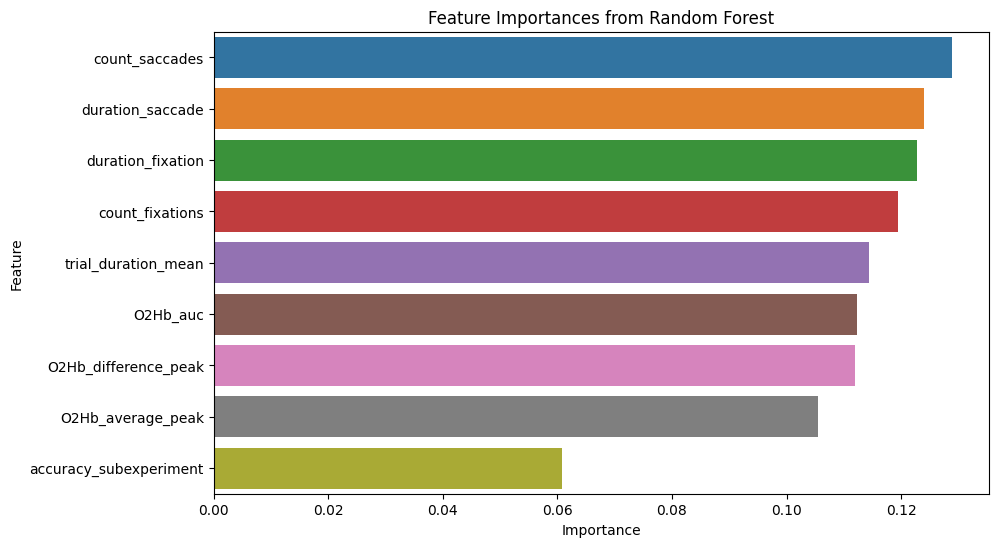

In [117]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'count_saccades', 'duration_fixation', 'duration_saccade', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['median_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Logistic Regression

In [111]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.39      0.50      0.44        96
weighted avg       0.59      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### Linear Discriminant Analysis

In [112]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.77      0.97      0.86        74

    accuracy                           0.75        96
   macro avg       0.38      0.49      0.43        96
weighted avg       0.59      0.75      0.66        96


Confusion Matrix:
[[ 0 22]
 [ 2 72]]


### Support Vector Machine

In [113]:
file_path = "master.csv"
df = pd.read_csv(file_path)

X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 'count_fixations', 'duration_fixation', 'accuracy_subexperiment', 'trial_duration_mean']]  # Features
y = df['tutorial_split_feedback_score_subexperiment']  # Target (Low or High)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters found: {grid.best_params_}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 100, 'class_weight': None, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       0.77      1.00      0.87        74

    accuracy                           0.77        96
   macro avg       0.89      0.50      0.44        96
weighted avg       0.82      0.77      0.67        96


Confusion Matrix:
[[ 0 22]
 [ 0 74]]


### K Means Clustering

C:\Users\Mobile Workstation 3\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


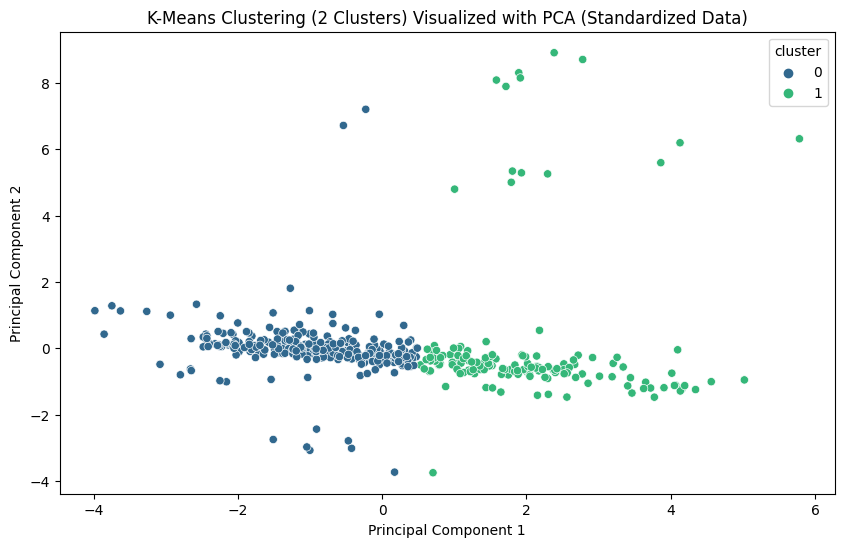

Explained variance by PC1 and PC2: [0.31029565 0.21933057]


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define features
X = df[['O2Hb_average_peak', 'O2Hb_auc', 'O2Hb_difference_peak', 
        'count_fixations', 'count_saccades', 
        'duration_fixation', 'duration_saccade', 
        'accuracy_subexperiment', 'trial_duration_mean']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with 2 clusters on scaled data
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Append the cluster labels to the DataFrame
df['cluster'] = clusters

# Reduce dimensions to 2 for visualization using PCA on scaled data
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis')
plt.title('K-Means Clustering (2 Clusters) Visualized with PCA (Standardized Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optional: Display explained variance ratio to know how much variance is captured
print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)